In [10]:
import glob

run_number    = 4735
outputfolder = "/Users/ansimez/Documents/InvCit/hdf5/{}/MonitorPlots/".format(run_number)
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps_*h5".format(run_number))

In [2]:
len(inputfiles)

499

In [7]:
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.database.load_db as dbf
import invisible_cities.io.table_io as tbiof
import invisible_cities.reco.tbl_functions as tbf
import invisible_cities.io.pmap_io as pmapio
import invisible_cities.reco.pmaps_functions_c  as pmapsfc

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels

from invisible_cities.core.system_of_units_c import units

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

Running on  Tue Oct 31 11:22:48 2017


In [8]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Load database

In [11]:
DataSiPM = dbf.DataSiPM(run_number)

## Functions

#### Function for some histo stats (mean and std)

In [12]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return [average, np.sqrt(variance)]

#### Functions for filling variables

In [13]:
def fillSvar (evt, s_file, sn, sw, sh, se, st, evt_ts, timestamp):
    try: 
        s = s_file[evt]
    except:
        sn.append(0)   
    else:
        peaks = s.peak_collection()
        sn.append(len(peaks))
        for npeak in peaks:
            peak = s.peak_waveform(npeak)
            sw.append(peak.width)
            sh.append(peak.height)
            se.append(np.sum(peak.E))
            st.append(np.mean(peak.t))
            evt_ts.append(timestamp)

In [14]:
def fillS2PMTvar (s2pmt, sw, sh, se, st, npmt):
    peaks = s2pmt.peak_collection()
    
    for npeak in peaks:
        sw_pmt = []
        sh_pmt = []
        se_pmt = []
        st_pmt = []
        for pmt in np.arange(0,npmt,1):
            peak = s2pmt.pmt_waveform(npeak,pmt)
            sw_pmt.append(peak.width)
            sh_pmt.append(peak.height)
            se_pmt.append(np.sum(peak.E))
            st_pmt.append(np.mean(peak.t))
        sw.append(sw_pmt)
        sh.append(sh_pmt)
        se.append(se_pmt)
        st.append(st_pmt)

In [15]:
def fillS2var (evt, s2_file, s2si_file, s2n, s2w, s2wthr, s2h, s2e, s2ethr, s2t, \
               s2sin, s2q, s2siID, s2qi, s2qmax, s2nsipm, s2_s2si_e,\
               s1n, s1e, s1t, s2_s1_e, s2_s1_t, onlyS1, \
               evt_tS2, evt_tS2si, evt_tS2sin, timestamp, thr):

    s2 = s2_file[evt]
    peaks = s2.peak_collection()
    s2n.append(len(peaks))
    try:
        s2si = s2si_file[evt]       
    except:
        s2sin.append(0)
    else:
        s2sin.append(len(s2si.s2sid))

    for npeak in peaks:
        peak = s2.peak_waveform(npeak)
        

        s2w.append(peak.width)
        s2wthr.append(peak.width_above_threshold(thr))
        s2h.append(peak.height)
        e = np.sum(peak.E)
        s2e.append(e)
        s2ethr.append(np.sum(peak.total_energy_above_threshold(thr)))
        s2t.append(np.mean(peak.t))
        evt_tS2.append(timestamp)
        
        if(s1n[-1]==1):
            s2_s1_e.append(s2e[-1]/s1e[-1])
            s2_s1_t.append(s2t[-1] - s1t[-1])
            onlyS1.append(True)
        else:
            onlyS1.append(False)
        
        q = 0
        try: 
            sipeaks = s2si.s2sid[npeak]
        except:
            pass
        else:
            evt_tS2si.append(timestamp)
            chargemax = -10000

            for ID, si in sipeaks.items():
                evt_tS2sin.append(timestamp)
                charge = np.sum(si)
                q += charge
                s2qi.append(charge)
                s2siID.append(ID)
                if charge>chargemax :
                    chargemax = charge
                
            s2q.append(q)
            s2qmax.append(chargemax)
            s2nsipm.append(len(sipeaks))
        s2_s2si_e.append(q/e)


#### Functions for plotting

In [16]:
def plotVar (var, bins, var_min, var_max, x_label, y_label, title, text="stats", log = False):
    n, x, y = hist(var, bins, [var_min, var_max])
    labels(x_label, y_label, title)
    mean = weighted_std(x, n)
    ypos_text = 0.85*np.max(n)

    if log:
        plt.yscale("log")
        
    if text == "stats":
        plt.text(x[len(x)//2], ypos_text, \
                "Mean = {0:.2f}\n".format(mean[0]) + \
                "RMS = {0:.2f}\n".format(mean[1]))        
    elif text == "":
        pass
    else:
        plt.text(x[len(x)//2], 0.85*np.max(n), text)
    
#    fig.savefig(outputfolder+title+".pdf")
    

In [17]:
def plotVarPMT (npmt, var, bins, var_min, var_max, x_label, y_label, title):
    fsize = 30
    
    n_row = 3
    nrows = npmt//n_row

    if npmt%n_row>0:
        nrows +=1
        
    fig, axes = plt.subplots(nrows, 3, figsize=(40,40))
    st = fig.suptitle(title, fontsize = 80)

    for pmt in range(npmt):
        axes[pmt//n_row][pmt%n_row].hist(var[:,pmt], bins, [var_min, var_max])
        axes[pmt//n_row][pmt%n_row].set_xlabel(x_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_ylabel(y_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_title("PMT {}".format(pmt), fontsize = fsize)

    fig.tight_layout()
    
    st.set_y(0.98)
    fig.subplots_adjust(top=0.93)
    
#    fig.savefig(outputfolder+title+"PMTs.pdf")
    

In [18]:
def plot2dVar(var1, var2, binx, biny, var1_min, var1_max, var2_min, var2_max, x_label, y_label, title, log = False):
    if log == True:
        hist2d(var1, var2, (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]], norm = LogNorm())
    else:
        hist2d(var1, var2, (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]])

    plt.colorbar().set_label("Entries")
    labels(x_label, y_label, title)
    
#    fig.savefig(outputfolder+title+".pdf")

In [19]:
def plot2dVarPMT(npmt, var1, var2, binx, biny, var1_min, var1_max, var2_min, var2_max, x_label, y_label, title):
    fsize = 30
    
    n_row = 3
    nrows = npmt//n_row

    if npmt%n_row>0:
        nrows +=1
        
    fig, axes = plt.subplots(nrows, 3, figsize=(40,40))
    st = fig.suptitle(title, fontsize = 80)

    for pmt in range(npmt):
        axes[pmt//n_row][pmt%n_row].hist2d(var1, var2[:,pmt], (binx, biny), [[var1_min, var1_max], [var2_min, var2_max]])
        axes[pmt//n_row][pmt%n_row].set_xlabel(x_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_ylabel(y_label, fontsize = fsize/2)
        axes[pmt//n_row][pmt%n_row].set_title("PMT {}".format(pmt), fontsize = fsize)

    fig.tight_layout()
    
    st.set_y(0.98)
    fig.subplots_adjust(top=0.93)
    
#    fig.savefig(outputfolder+title+"PMTs.pdf")

In [20]:
def CreatePlotsS(sn, sw, sh, se, st, tE, tS, stype, smin, smax):

    ### Number of peaks
    textPrint = "Total number = {0}\n".format(sn.sum()) + \
            "Higher than 10 = {0}\n".format(len(sn[sn>10])) + \
            "Events with 1 = {0}".format(len(sn[sn==1]))
    plotVar(sn, 10, 0, 10, "# " + stype, "Entries", stype + " number", text  = textPrint)

    ### Width
    plotVar(sw, 100, sw.min(), sw.max(), "Width (ns)", "Entries", stype + " width", text = "", log = True)
    plotVar(sw, 100, smin['w'], smax['w'], "Width (ns)", "Entries", stype + " width (zoom)")

    ### Height
    plotVar(sh, 100, sh.min(), sh.max(), "Height (pes)", "Entries", stype + " height", text = "", log = True)
    plotVar(sh, 100, smin['h'], smax['h'], "Height (pes)", "Entries", stype + " height (zoom)")

    ### Energy
    plotVar(se, 100, se.min(), se.max(), "Energy (pes)", "Entries", stype + " energy", text = "", log = True)
    plotVar(se, 100, smin['e'], smax['e'], "Energy (pes)", "Entries", stype + " energy (zoom)")
    
    ### Time position
    plotVar(st, 100, st.min(), st.max(), "Time ($\mu$s)", "Entries", stype + " time position", text = "")

    ### Number vs time
    plot2dVar(tE, sn, 50, 10, tE.min(), tE.max(), 0., 10.,\
              "Event time (s)", "# " + stype, stype + " number vs timestamp")

    ### Energy vs time    
    plot2dVar(tS, se, 50, 50, tS.min(), tS.max(), smin['e'], smax['e'],\
              "Event time (s)", "Energy (pes)", stype + " energy vs timestamp") 

In [21]:
def CreatePlotsSi(sn, q, ID, qi, qimax, nsipm, tE, tS, smin, smax):
    ### Number of peaks
    textPrint = "Total number = {0}\n".format(sn.sum()) + \
                 "With 0 peaks = {0}\n".format(len(sn[sn==0])) + \
                 "Events with 1 = {0}".format(len(sn[sn==1]))
    plotVar(sn, 10, 0, 10, "# S2Si", "Entries", "S2Si number", text  = textPrint)
    
    ### Charge
    plotVar(q, 100, q.min(), q.max(), "Total charge (pes)", "Entries", "S2Si charge", text = "", log = True)
    plotVar(q, 100, smin['q'], smax['q'], "Total charge (pes)", "Entries", "S2Si charge (zoom)")

    ### SiPM charge
    plotVar(qi, 100, qi.min(), qi.max(), "SiPM charge (pes)", "Entries", "SiPM charge", text = "", log = True)
    plotVar(qi, 100, smin['qi'], smax['qi'], "SiPM charge (pes)", "Entries", "SiPM charge (zoom)")
    
    
    ### SiPM max charge
    plotVar(qimax, 100, qimax.min(), qimax.max(), "SiPM max charge (pes)", "Entries", "SiPM max charge", text = "", log = True)
    plotVar(qimax, 100, smin['qimax'], smax['qimax'], "SiPM max charge (pes)", "Entries", "SiPM max charge (zoom)")
    
    ### SiPM max fraction
    qfrac = qimax/q
    plotVar(qfrac, 100, 0., 1., "SiPM max charge (%)", "Entries", "SiPM max charge fraction")

    ### SiPMs touched
    plotVar(nsipm, 1792, 0, 1792, "# touched SiPMs", "Entries", "SiPM number")
 
    ### Detections per SiPM
    plotVar(ID, 1792, 0, 1792, "Channel ID", "# of detections", "SiPM detections")
    
    ### Number vs time
    plot2dVar(tE, sn, 50, 10, tE.min(), tE.max(), 0., 10.,\
              "Event time (s)", "# S2S1", "S2Si number vs timestamp")
    
    ### Charge vs time
    plot2dVar(tS, q, 50, 50, tS.min(), tS.max(), smin['q'], smax['q'],\
              "Event time (s)", "S2Si charge (pes)", "S2Si charge vs timestamp")
    
    ### Detections per SiPM (2D)
    plot2dVar(DataSiPM.X.values[ID], DataSiPM.Y.values[ID], 40, 40, -200., 200., -200., 200.,\
              "x (mm)", "y (mm)", "SiPM detections (2D)")

In [22]:
def CreatePlotsS1S2Si(s2e, s2s1e, s2s1t, s2sie, tS, onlyS1, smin, smax):

    #S2/S1 ratio
    plotVar(s2s1e, 100, s2s1e.min(), s2s1e.max(), "Ratio", "Entries", "S2/S1 ratio", text = "", log = True)
    plotVar(s2s1e, 100, smin['s2s1e'], smax['s2s1e'], "Ratio", "Entries", "S2/S1 ratio (zoom)")
    
    #S2/S1 time difference
    plotVar(s2s1t, 100, s2s1t.min(), s2s1t.max(), \
            "Time difference ($\mu$s)", "Entries", "S2 - S1 time difference", text = "")

    #Si/S2 ratio
    plotVar(s2sie, 100, s2sie.min(), s2sie.max(), "Ratio", "Entries", "Si/S2 ratio", text = "", log = True)
    plotVar(s2sie, 100, smin['s2sie'], smax['s2sie'], "Ratio", "Entries", "Si/S2 ratio (zoom)")
    
    ### S2 vs S1 charge
    s1e = s2e[onlyS1]/s2s1e
    plot2dVar(s2e[onlyS1], s1e, 50, 50, 0., s2e.max(), 0., s1e.max(),\
              "S2 energy (pes)", "S1 energy (pes)", "S2 charge vs S1 charge", log = True)    
    plot2dVar(s2e[onlyS1], s1e, 50, 50, smin['s2e'], smax['s2e'], smin['s1e'], smax['s1e'],\
              "S2 energy (pes)", "S1 energy (pes)", "S2 charge vs S1 charge (zoom)")

    ### S2/S1 vs time
    plot2dVar(tS[onlyS1], s2s1e, 50, 50, tS.min(), tS.max(), 0., s2s1e.max(),\
              "Event time (s)", "Ratio", "S2/S1 ratio vs timestamp", log = True)
    plot2dVar(tS[onlyS1], s2s1e, 50, 50, tS.min(), tS.max(), smin['s2s1e'], smax['s2s1e'],\
              "Event time (s)", "Ratio", "S2/S1 ratio vs timestamp (zoom)")
    
    ### S2/S1 time difference vs time
    plot2dVar(tS[onlyS1], s2s1t, 50, 50, tS.min(), tS.max(), s2s1t.min(), s2s1t.max(),\
              "Event time (s)", "Time difference ($\mu$s)", "S2/S1 time difference vs timestamp")

    ###Si/S2 vs time
    plot2dVar(tS, s2sie, 50, 50, tS.min(), tS.max(), 0., s2sie.max(),\
              "Event time (s)", "Ratio", "Si/S2 ratio vs timestamp", log = True)
    plot2dVar(tS, s2sie, 50, 50, tS.min(), tS.max(), smin['s2sie'], smax['s2sie'],\
              "Event time (s)", "Ratio", "Si/S2 ratio vs timestamp (zoom)")    

    ### S2/S1 vs S2 energy
    plot2dVar(s2e[onlyS1], s2s1e, 50, 50, 0., s2e.max(), 0., s2s1e.max(),\
              "S2 energy (pes)", "Ratio", "S2/S1 ratio vs S2 energy", log = True)
    plot2dVar(s2e[onlyS1], s2s1e, 50, 50, smin['s2e'], smax['s2e'], smin['s2s1e'], smax['s2s1e'],\
              "S2 energy (pes)", "Ratio", "S2/S1 ratio vs S2 energy (zoom)")
    
    ### S2/S1 time difference vs S2 energy
    plot2dVar(s2e[onlyS1], s2s1t, 50, 50, 0., s2e.max(), s2s1t.min(), s2s1t.max(),\
              "S2 energy (pes)", "Time difference ($\mu$s)", "S2/S1 time difference vs S2 energy", log = True)
    plot2dVar(s2e[onlyS1], s2s1t, 50, 50, smin['s2e'], smax['s2e'], s2s1t.min(), s2s1t.max(),\
              "S2 energy (pes)", "Time difference ($\mu$s)", "S2/S1 time difference vs S2 energy (zoom)")
    
    ###Si/S2 vs S2 energy
    plot2dVar(s2e, s2sie, 50, 50, 0., s2e.max(), 0., s2sie.max(),\
              "S2 energy (pes)", "Ratio", "Si/S2 ratio vs S2 energy", log = True)
    plot2dVar(s2e, s2sie, 50, 50, smin['s2ratio'], smax['s2e'], smin['s2sie'], smax['s2sie'],\
              "S2 energy (pes)", "Ratio", "Si/S2 ratio vs S2 energy (zoom)")   
    
    ###Si/S2 vs S2/S1 time difference
    plot2dVar(s2s1t, s2sie[onlyS1], 50, 50, s2s1t.min(), s2s1t.max(), 0., s2sie.max(),\
              "Time difference ($\mu$s)", "Ratio", "Si/S2 ratio vs S2/S1 time diff", log = True)
    plot2dVar(s2s1t, s2sie[onlyS1], 50, 50, s2s1t.min(), s2s1t.max(), smin['s2sie'], smax['s2sie'],\
              "Time difference ($\mu$s)", "Ratio", "Si/S2 ratio vs S2/S1 time diff (zoom)")            
    
    ### S2/S1 vs S2/S1 time difference
    plot2dVar(s2s1t, s2s1e, 50, 50, s2s1t.min(), s2s1t.max(), 0., s2s1e.max(),\
              "Time difference ($\mu$s)", "Ratio", "S2/S1 ratio vs S2/S1 time diff", log = True)
    plot2dVar(s2s1t, s2s1e, 50, 50, s2s1t.min(), s2s1t.max(), smin['s2s1e'], smax['s2s1e'],\
              "Time difference ($\mu$s)", "Ratio", "S2/S1 ratio vs S2/S1 time diff (zoom)") 

In [23]:
def CreatePlotsSPMT(sw, sh, se, st, tE, smin, smax, npmt):
    ### Width
    plotVarPMT(npmt, sw, 100, smin['w'], smax['w'], "Width (ns)", "Entries", "Width")

    ### Height    
    plotVarPMT(npmt, sh, 100, smin['h']/npmt, smax['h']/npmt, "Height (pes)", "Entries", "Height")

    ### Energy
    plotVarPMT(npmt, se, 100, smin['e']/npmt, smax['e']/npmt, "Energy (pes)", "Entries", "Energy")

    ### Time position
    plotVarPMT(npmt, st, 100, st.min(), st.max(), "Time position ($\mu$s)", "Entries", "Time position")
    
    ### Width vs timestamp
    plot2dVarPMT(npmt, tE, sw, 50, 50, tE.min(), tE.max(), \
                 minS2['w'], maxS2['w'], "Time ($\mu$s)", "Width (ns)", "Width vs timestamp")    

    ### Height vs timestamp
    plot2dVarPMT(npmt, tE, sh, 50, 50, tE.min(), tE.max(), \
                 minS2['h']/npmt, maxS2['h']/npmt, "Time ($\mu$s)", "Height (pes)", "Height vs timestamp") 

    ### Energy vs timestamp
    plot2dVarPMT(npmt, tE, se, 50, 50, tE.min(), tE.max(), \
                 minS2['e']/npmt, maxS2['e']/npmt, "Time ($\mu$s)", "Energy (pes)", "Energy vs timestamp") 

    ### Time position vs timestamp
    plot2dVarPMT(npmt, tE, st, 50, 50, tE.min(), tE.max(), \
                 st.min(), st.max(), "Time ($\mu$s)", "Time position ($\mu$s)", "Time vs timestamp")

# Load pmaps and values

In [24]:
s1n = []
s1w = []
s1h = []
s1e = []
s1t = []

s2n = []
s2w = []
s2wthr = []
s2h = []
s2e = []
s2ethr = []
s2t = []

s2sin = []
s2q = []
s2siID = []
s2qi = []
s2qmax = []
s2nsipm = []

s2pmtw = []
s2pmth = []
s2pmte = []
s2pmtt = []

s2_s1_e = []
s2_s1_t = []
s2_s2si_e = []

onlyS1 = []

evt_t = []
evt_tS1 = []
evt_tS2 = []
evt_tS2si = []
evt_tS2sin = []

npmt = 11

for file in inputfiles[:200]:
    try: 
        s1_file, s2_file, s2si_file = pmapio.load_pmaps(file)
    except: 
        print("File {} could not be opened".format(file))
    else:
        timestamp = tbf.get_event_numbers_and_timestamps_from_file_name(file)[1]
        for i, evt in enumerate(s2_file):
            evt_t.append(timestamp[i])
            fillSvar(evt, s1_file, s1n, s1w, s1h, s1e, s1t, evt_tS1, timestamp[i])
            fillS2var(evt, s2_file, s2si_file, s2n, s2w, s2wthr, s2h, s2e, s2ethr, s2t, \
                      s2sin, s2q, s2siID, s2qi, s2qmax, s2nsipm, s2_s2si_e, \
                      s1n, s1e, s1t, s2_s1_e, s2_s1_t, onlyS1, \
                      evt_tS2, evt_tS2si, evt_tS2sin, timestamp[i], thr=0.*units.pes)
#            fillS2PMTvar(s2pmt_file[evt], s2pmtw, s2pmth, s2pmte, s2pmtt, npmt)

evt_t = (evt_t-evt_t[0])/1000.
evt_tS1 = (evt_tS1-evt_tS1[0])/1000.
evt_tS2 = (evt_tS2-evt_tS2[0])/1000.
evt_tS2si = (evt_tS2si-evt_tS2si[0])/1000.
s2pmtw = np.array(s2pmtw)
s2pmth = np.array(s2pmth)
s2pmte = np.array(s2pmte)
s2pmtt = np.array(s2pmtt)

In [26]:
s1n = np.array(s1n)
s1w = np.array(s1w)
s1h = np.array(s1h)
s1e = np.array(s1e)
s1t = np.array(s1t)

s2n = np.array(s2n)
s2w = np.array(s2w)
s2h = np.array(s2h)
s2e = np.array(s2e)
s2t = np.array(s2t)

s2sin = np.array(s2sin)
s2q = np.array(s2q)
s2siID = np.array(s2siID)
s2qi = np.array(s2qi)
s2qmax = np.array(s2qmax)
s2nsipm = np.array(s2nsipm)

s2_s1_e = np.array(s2_s1_e)
s2_s1_t = np.array(s2_s1_t)
s2_s2si_e = np.array(s2_s2si_e)

onlyS1 = np.array(onlyS1)

evt_t = np.array(evt_t)
evt_tS1 = np.array(evt_tS1)
evt_tS2 = np.array(evt_tS2)
evt_tS2si = np.array(evt_tS2si)
evt_tS2sin = np.array(evt_tS2sin)

# Plots

### Plotting limits

In [32]:
minS1 = {'w':0, 'h':5, 'e':0}
maxS1 = {'w':1000, 'h':150, 'e':1000}

minS2 = {'w':0, 'h':0, 'e':0}
maxS2 = {'w':100e3, 'h':30e3, 'e':600e3}

minS2Si = {'q':0, 'qi':80, 'qimax':0, 'nsipm':0}
maxS2Si = {'q':90e3, 'qi':3000, 'qimax':3000, 'nsipm':500}

minRatio = {'s1e': 0, 's2e':75e3, 's2s1e':0, 's2sie':0., 's2ratio':1000}
maxRatio = {'s1e': 500, 's2e':500e3, 's2s1e':2500, 's2sie':0.5, 's2ratio':500e3}

### S1 plots

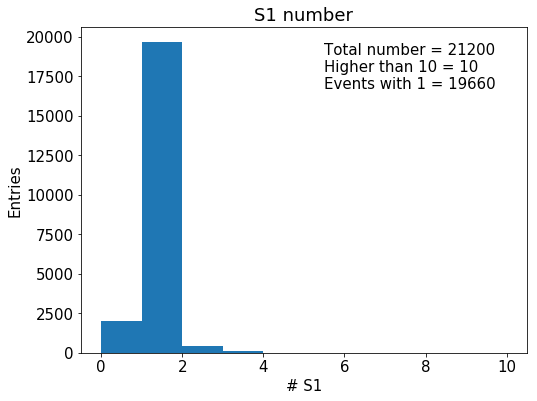

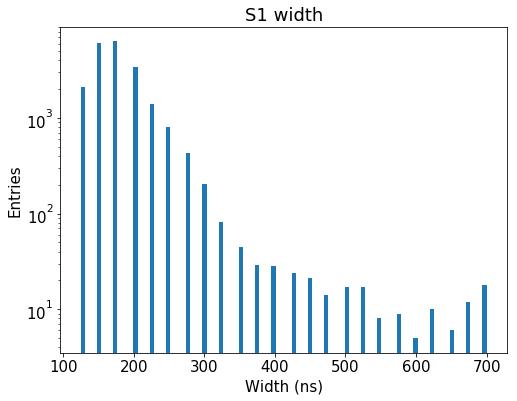

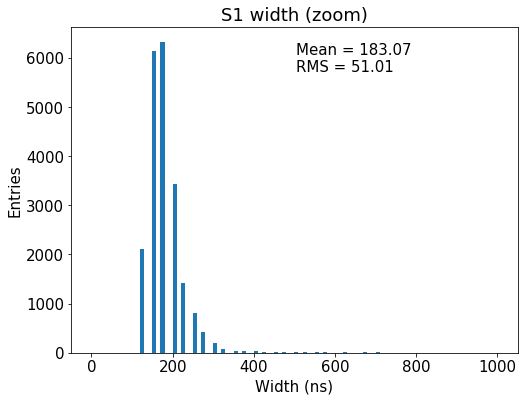

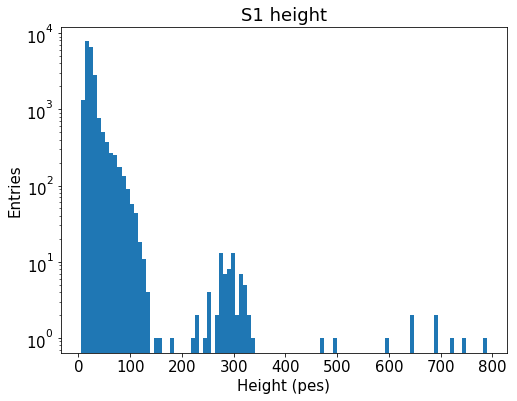

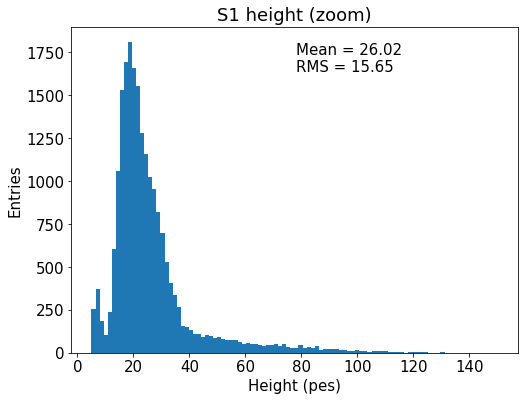

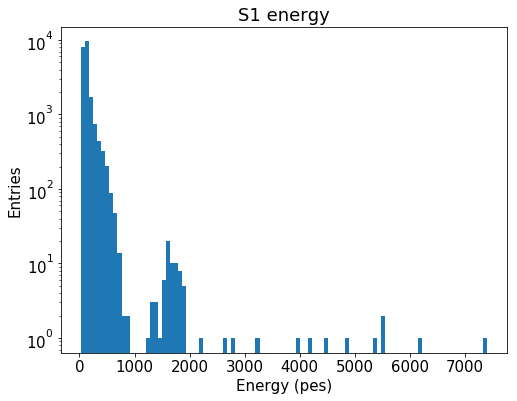

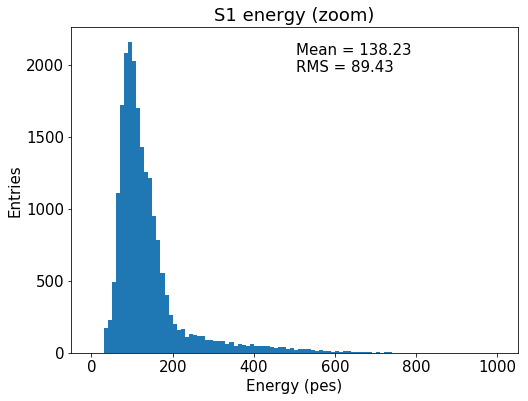

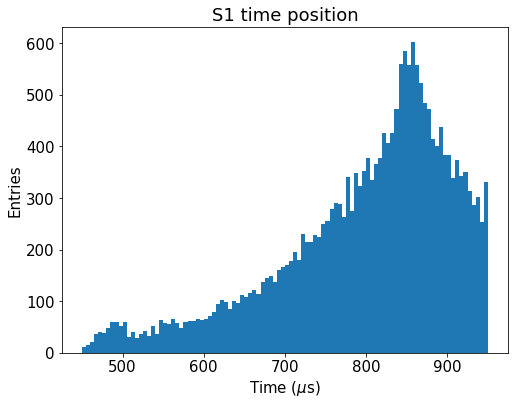

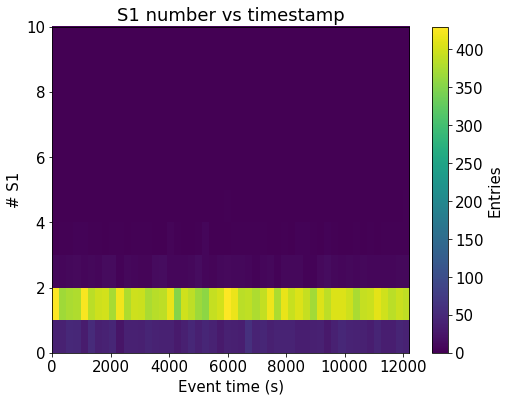

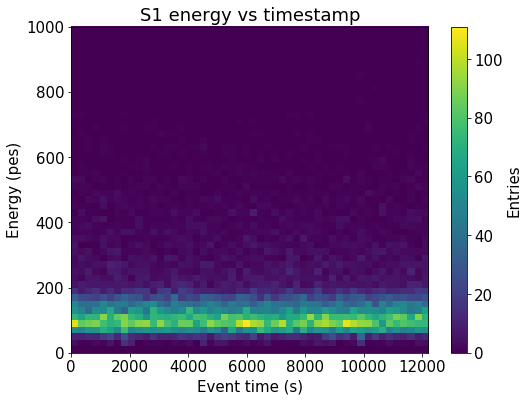

In [33]:
CreatePlotsS(np.asarray(s1n), np.asarray(s1w), np.asarray(s1h), np.asarray(s1e), \
             np.asarray(s1t)/1000., evt_t, evt_tS1, "S1", minS1, maxS1)

### S2 plots

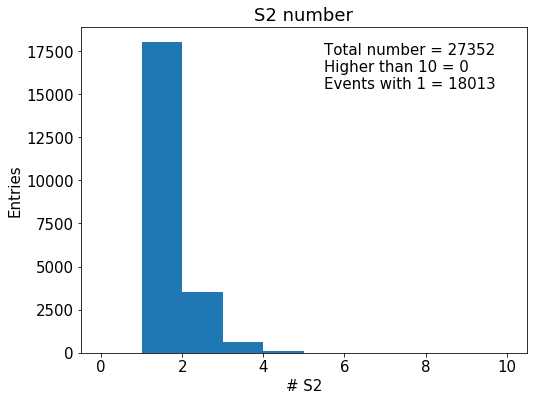

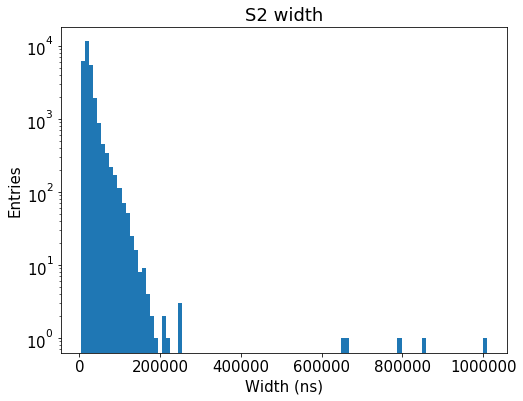

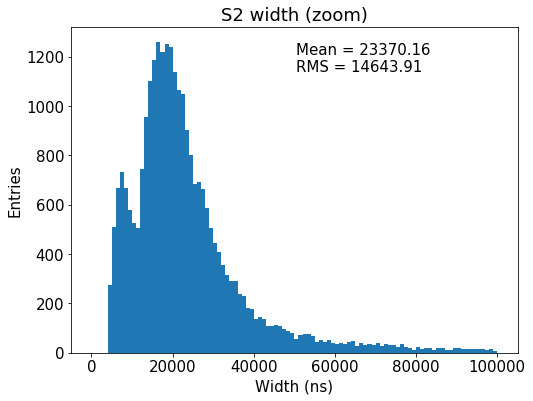

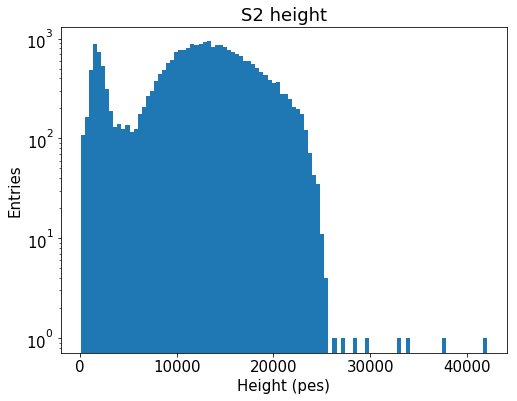

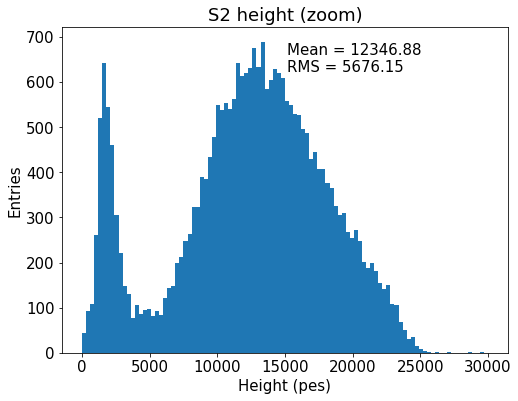

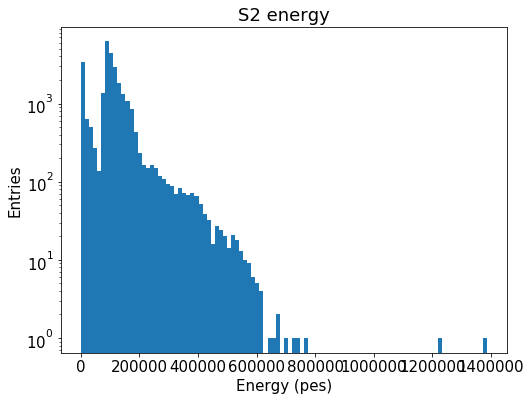

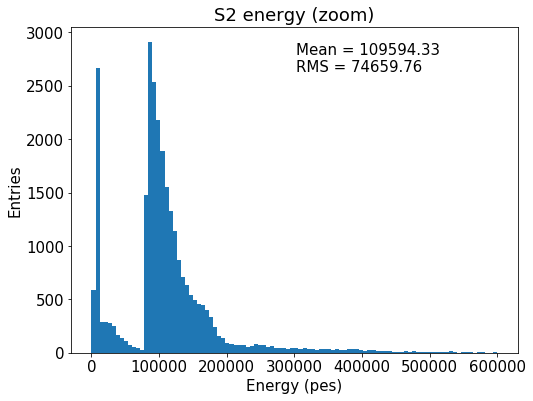

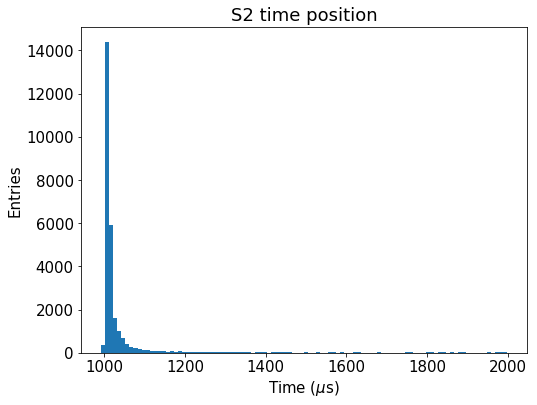

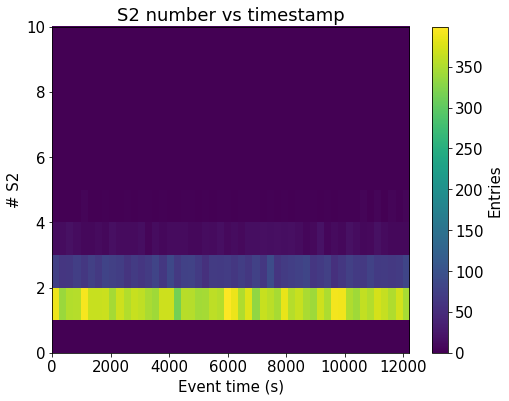

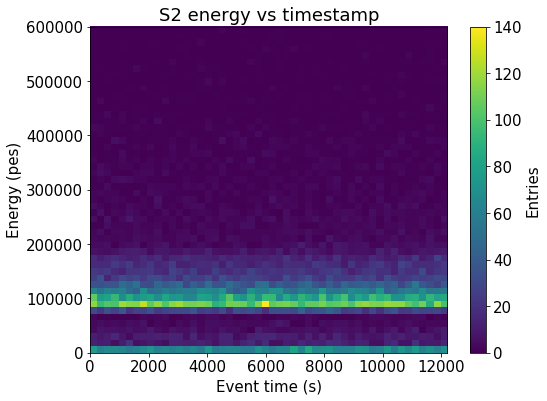

In [34]:
CreatePlotsS(np.asarray(s2n), np.asarray(s2w), np.asarray(s2h), np.asarray(s2e), \
             np.asarray(s2t)/1000., evt_t, evt_tS2, "S2", minS2, maxS2)

### S2Si plots

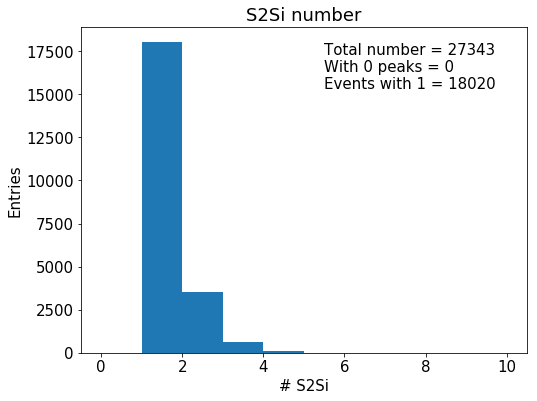

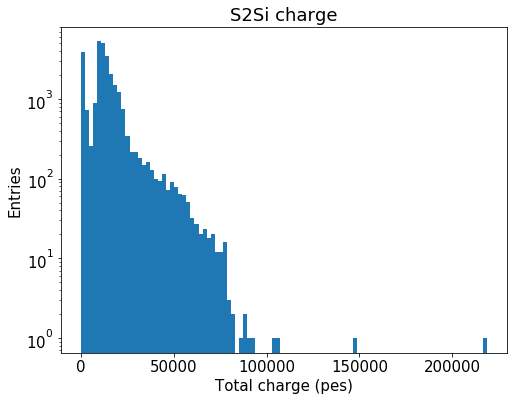

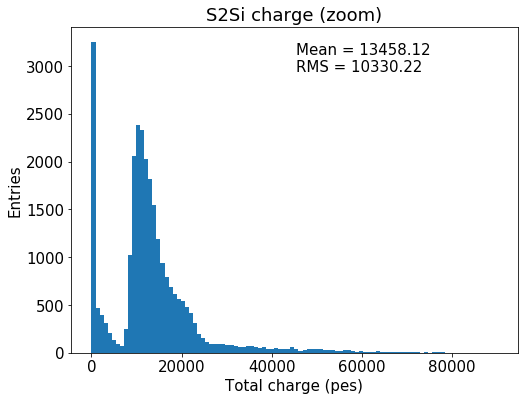

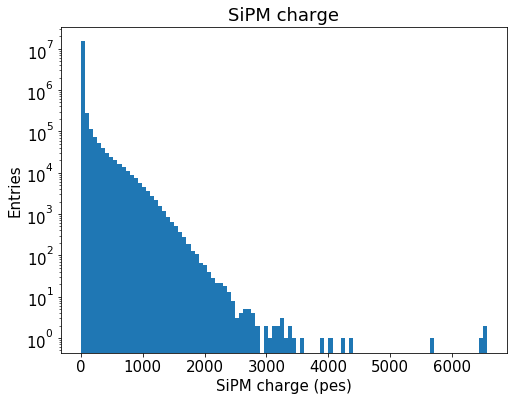

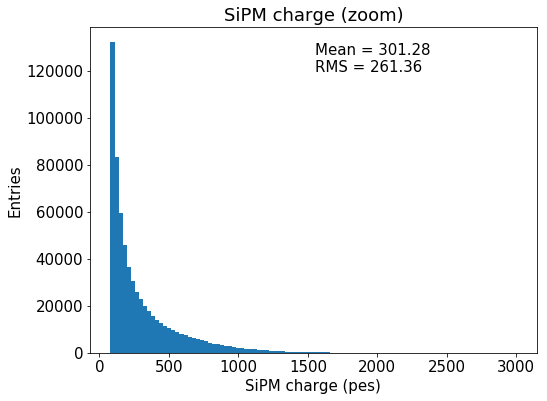

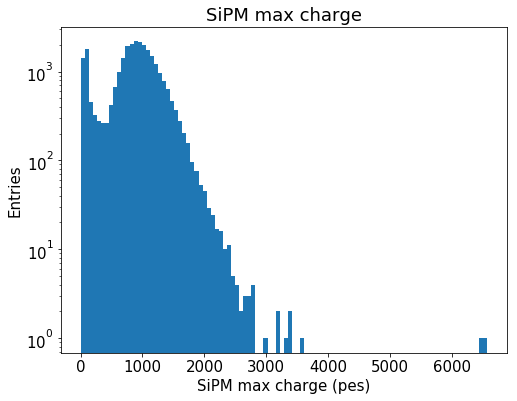

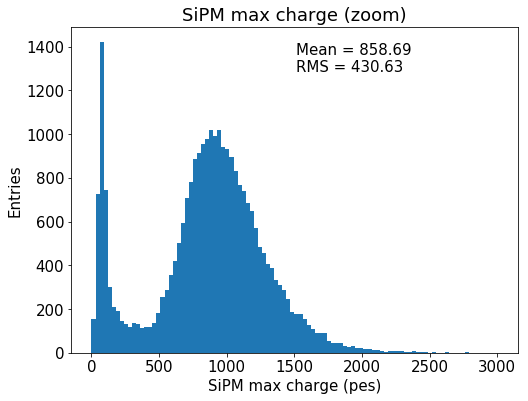

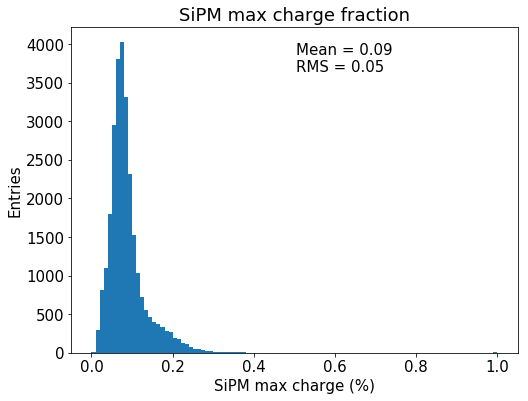

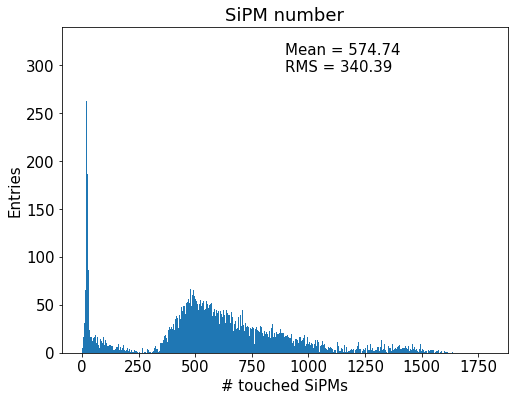

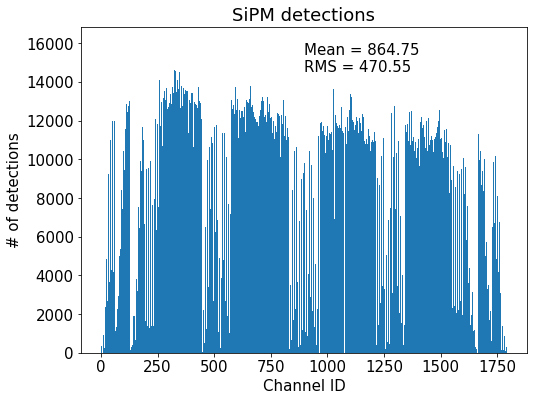

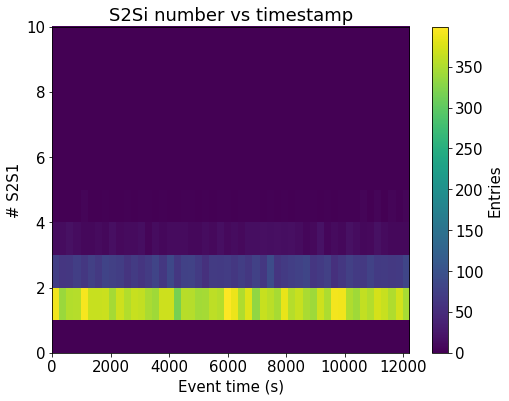

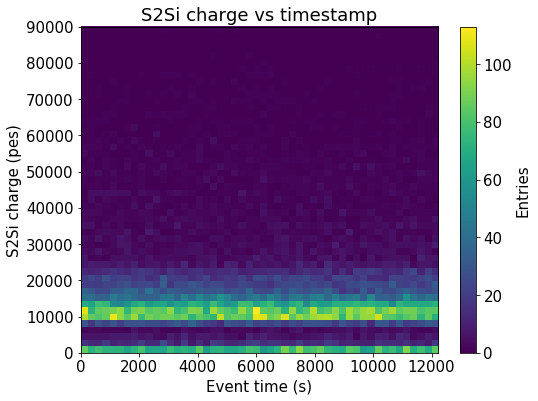

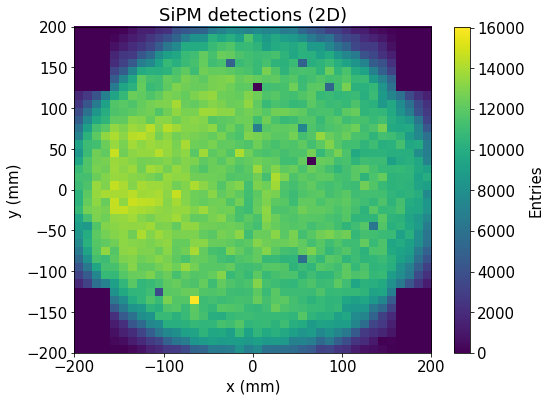

In [35]:
CreatePlotsSi(np.asarray(s2sin), np.asarray(s2q), np.asarray(s2siID), np.asarray(s2qi), \
              np.asarray(s2qmax), np.asarray(s2nsipm), evt_t, evt_tS2si, minS2Si, maxS2Si)


### Ratio plots

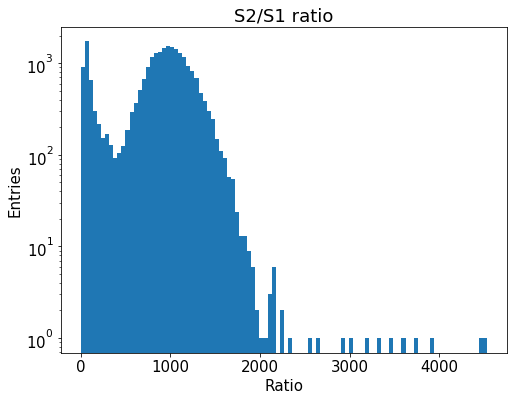

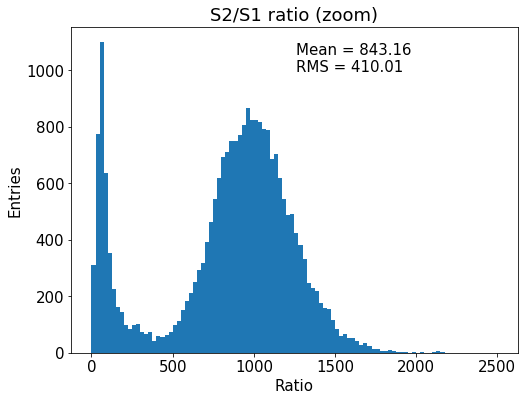

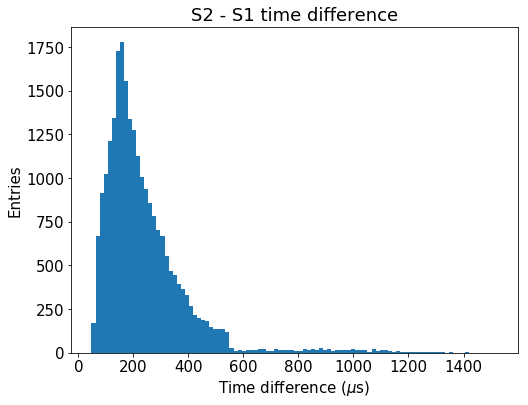

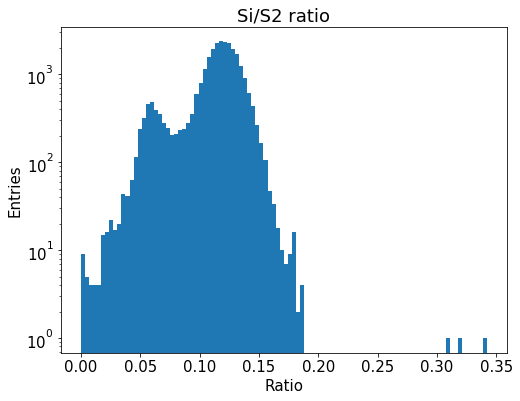

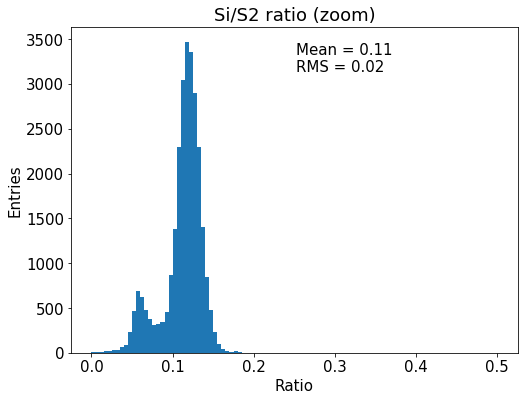

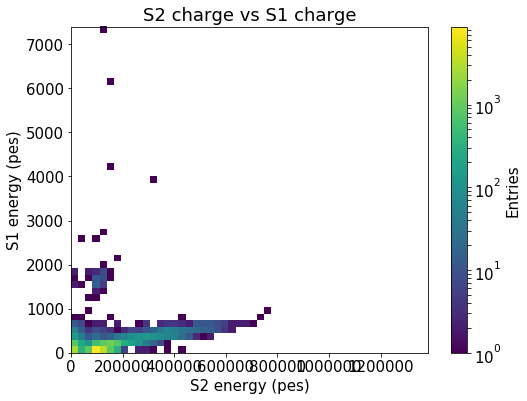

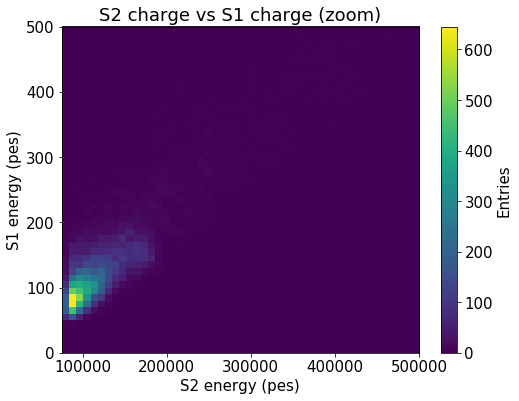

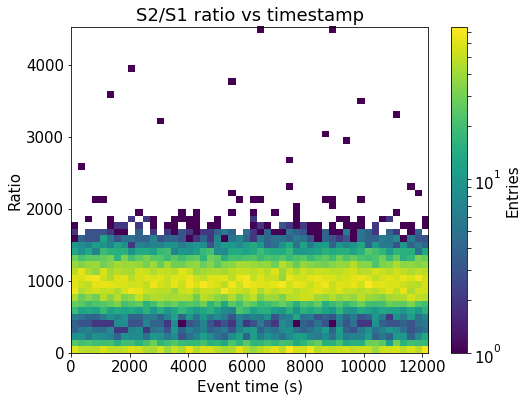

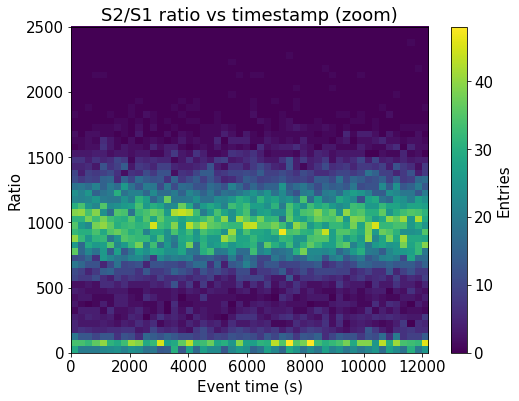

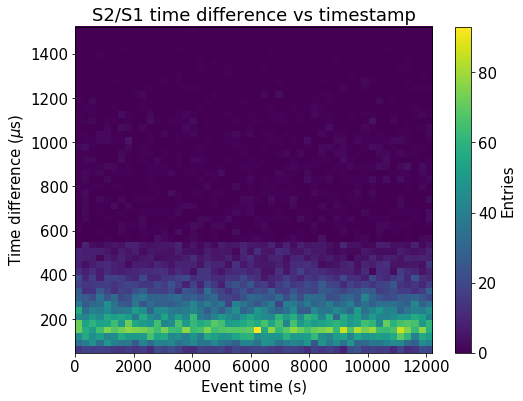

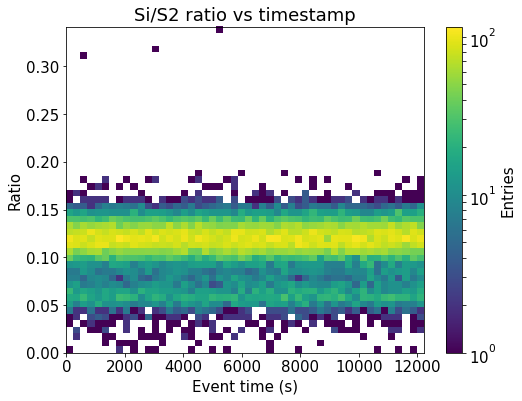

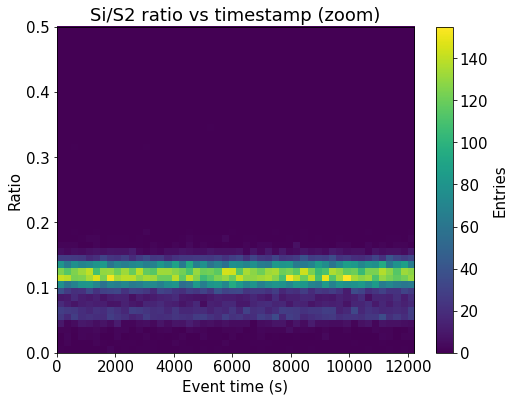

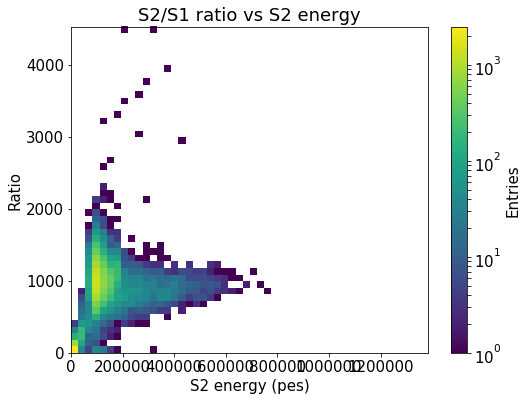

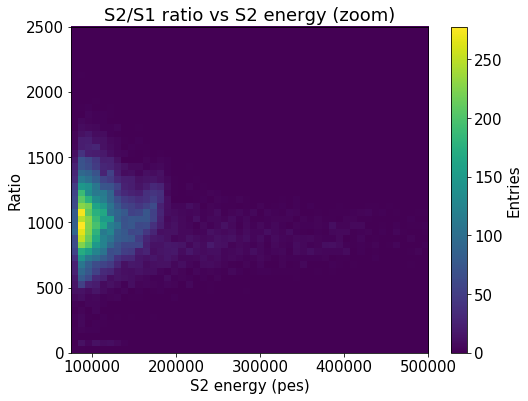

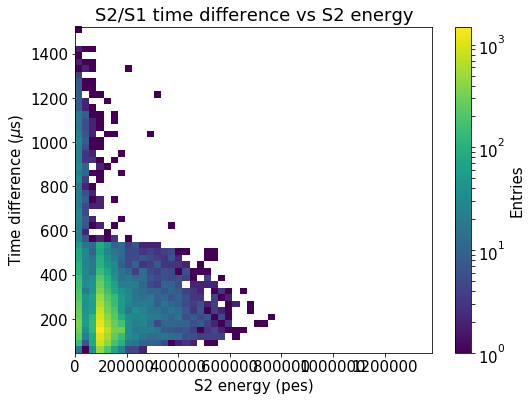

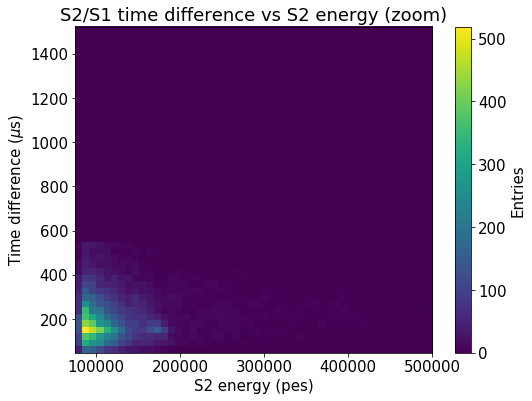

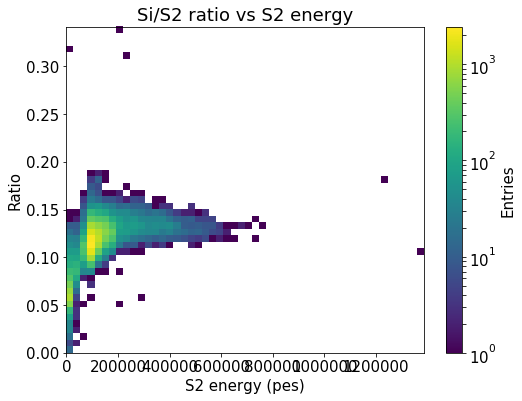

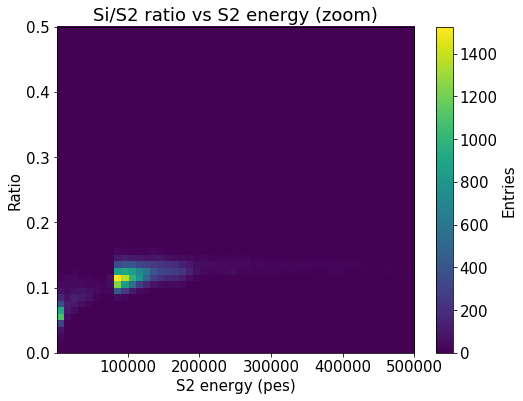

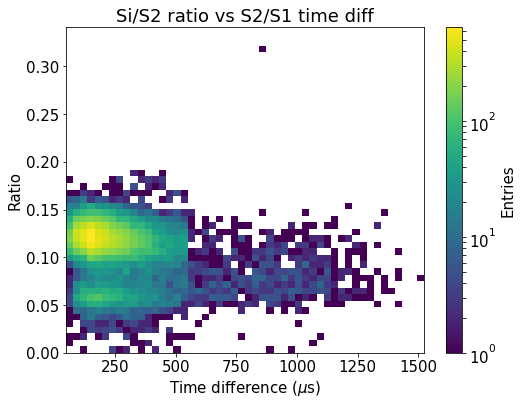

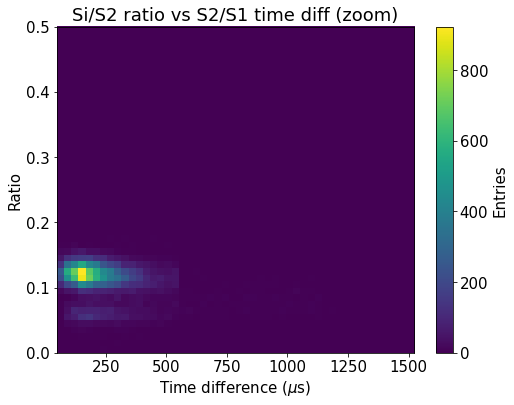

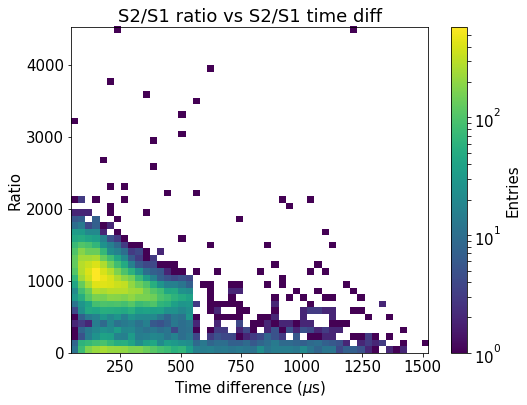

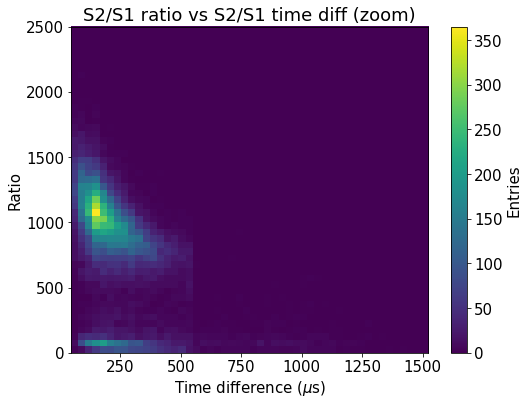

In [36]:
CreatePlotsS1S2Si(np.asarray(s2e), np.asarray(s2_s1_e), np.asarray(s2_s1_t)/1000., \
                  np.asarray(s2_s2si_e), np.asarray(evt_tS2), np.asarray(onlyS1), minRatio, maxRatio)

### S2pmt plots

In [ ]:
CreatePlotsSPMT(s2pmtw, s2pmth, s2pmte, s2pmtt/1000., np.asarray(evt_tS2), minS2, maxS2, 11)